In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].replace(0, np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].replace(0, np.nan)
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].replace(0, np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['NPOC_uM'] = df_doc['NPOC_uM'].replace(0, np.nan)
df_doc['TN_uM'] = df_doc['TN_uM'].replace(0, np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

In [6]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)

df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [7]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [8]:
df_spectra_bc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_BC.csv',sep=',', index_col=0)
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_wc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_WC.csv',sep=',', index_col=0)
df_spectra_rz = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

df_spectra_bc.columns = ['a' + col for col in df_spectra_bc.columns]
df_spectra_pw.columns = ['a' + col for col in df_spectra_pw.columns]
df_spectra_wc.columns = ['a' + col for col in df_spectra_wc.columns]
df_spectra_rz.columns = ['a' + col for col in df_spectra_rz.columns]

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\789686475.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)


In [9]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [10]:
#Put all the BC data together 
#remove repeat rows 
df_cdom_bc_cl = df_cdom_bc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_bc_cl = df_iron_bc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_bc_cl = df_doc_bc.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_bc_cl.index = df_cdom_bc_cl.index.astype(str)
df_iron_bc_cl.index = df_iron_bc_cl.index.astype(str)
df_doc_bc_cl.index = df_doc_bc_cl.index.astype(str)
df_spectra_bc.index = df_spectra_bc.index.astype(str)


#combind DOC and CDOM data 
df_bc = df_spectra_bc.join(df_doc_bc_cl)
df_bc = df_bc.join(df_cdom_bc_cl)

#match up the inxdes for the merge 
df_iron_bc_cl['sample_index'] = df_iron_bc_cl.index.astype(str)
df_bc.index = df_bc.index.astype(str)

#combind the iron data 
df_bc = df_bc.join(df_iron_bc_cl)
df_meta.index = df_meta.index.astype(str)

df_bc = df_meta.merge(df_bc, left_index=True, right_index=True)

#################################################

#Put all the PW data together 
#remove repeat rows 
df_cdom_pw_cl = df_cdom_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_pw_cl = df_iron_pw.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_pw_cl = df_doc_pw.drop(['Treatment','Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_pw_cl.index = df_cdom_pw_cl.index.astype(str)
df_iron_pw_cl.index = df_iron_pw_cl.index.astype(str)
df_doc_pw_cl.index = df_doc_pw_cl.index.astype(str)
df_spectra_pw.index = df_spectra_pw.index.astype(str)


#combind DOC and CDOM data 
df_pw = df_spectra_pw.join(df_doc_pw_cl)
df_pw = df_pw.join(df_cdom_pw_cl)

#match up the inxdes for the merge 
df_iron_pw_cl['sample_index'] = df_iron_pw_cl.index.astype(str)
df_pw.index = df_pw.index.astype(str)

#combind the iron data 
df_pw = df_pw.join(df_iron_pw_cl)

df_pw = df_meta.merge(df_pw, left_index=True, right_index=True)

###############################################

#Put all the WC data together 
#remove repeat rows 
df_cdom_wc_cl = df_cdom_wc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_wc_cl = df_iron_wc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_wc_cl = df_doc_wc.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_wc_cl.index = df_cdom_wc_cl.index.astype(str)
df_iron_wc_cl.index = df_iron_wc_cl.index.astype(str)
df_doc_wc_cl.index = df_doc_wc_cl.index.astype(str)
df_spectra_wc.index = df_spectra_wc.index.astype(str)

#combind DOC and CDOM data 
df_wc = df_spectra_wc.join(df_doc_wc_cl)
df_wc = df_wc.join(df_cdom_wc_cl)

#match up the inxdes for the merge 
df_iron_wc_cl['sample_index'] = df_iron_wc_cl.index.astype(str)
df_wc.index = df_wc.index.astype(str)

#combind the iron data 
df_wc = df_wc.join(df_iron_wc_cl)

df_wc = df_meta.merge(df_wc, left_index=True, right_index=True)

##################################################

#Put all the RZ data together 
#remove repeat rows 
df_cdom_rz_cl = df_cdom_rz.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_rz_cl = df_iron_rz.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_rz_cl = df_doc_rz.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_rz_cl.index = df_cdom_rz_cl.index.astype(str)
df_iron_rz_cl.index = df_iron_rz_cl.index.astype(str)
df_doc_rz_cl.index = df_doc_rz_cl.index.astype(str)
df_spectra_rz.index = df_spectra_rz.index.astype(str)

#combind DOC and CDOM data 
df_rz = df_spectra_rz.join(df_doc_rz_cl)
df_rz = df_rz.join(df_cdom_rz_cl)

#match up the inxdes for the merge 
df_iron_rz_cl['sample_index'] = df_iron_rz_cl.index.astype(str)
df_rz.index = df_rz.index.astype(str)

#combind the iron data 
df_rz = df_rz.join(df_iron_rz_cl)

#add the meta data 
df_rz = df_meta.merge(df_rz, left_index=True, right_index=True)

In [11]:
#litte clean ups with outliters 
df_pw.loc[df_pw['NPOC_uM'] > 4000, 'NPOC_uM'] = np.nan

df_bc.loc[df_bc['FeT_uM'] > 1, 'FeT_uM'] = np.nan
df_bc.loc[df_bc['Fe3_uM'] > 1, 'Fe3_uM'] = np.nan
df_bc.loc[df_bc['FeT_uM'] == 0, 'FeT_uM'] = np.nan
df_bc.loc[df_bc['Fe3_uM'] == 0, 'Fe3_uM'] = np.nan
df_bc.loc[df_bc['Fe2_uM'] == 0, 'Fe2_uM'] = np.nan

df_bc.loc[df_bc['a350'] > 2, 'a350'] = np.nan
df_bc.loc[df_bc['a412'] > 1.5, 'a412'] = np.nan
df_bc.loc[df_bc['NPOC_uM'] < .000005, 'NPOC_uM'] = np.nan
df_bc.loc[df_bc['TN_uM'] < .000005, 'TN_uM'] = np.nan

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\724613838.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\724613838.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\724613838.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData

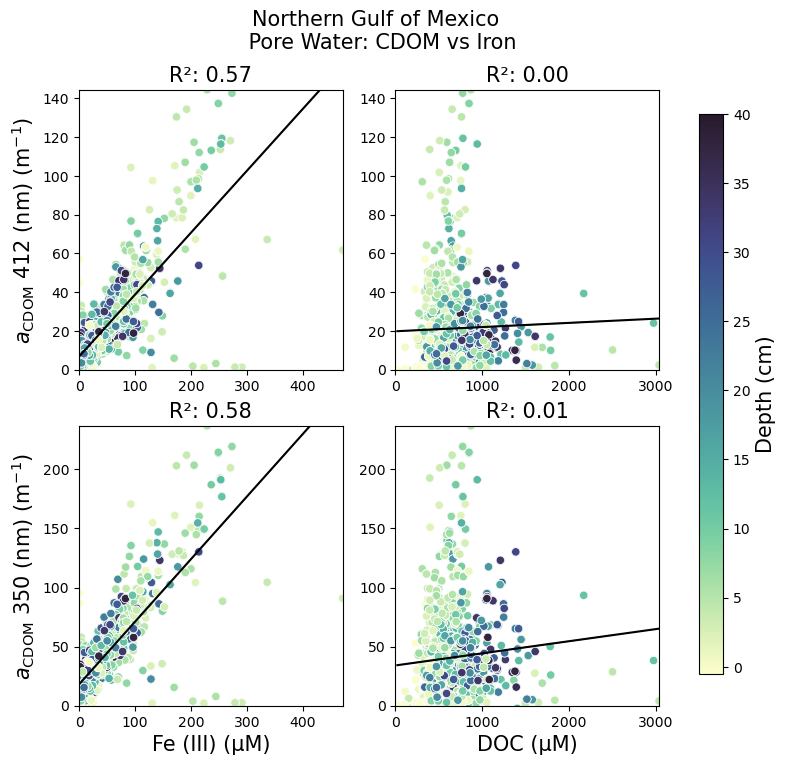

In [12]:
def cor_plot_stn_sum(data_frame, title, save_name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    
    # Set up the color bar limits
    vmin = -.5
    vmax = 40

    # Loop through the subplots
    for i, x_var in enumerate(['Fe3_uM', 'NPOC_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Sample_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Sample_depth'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

df = df_pw
cor_plot_stn_sum(df, f'Northern Gulf of Mexico \n Pore Water: CDOM vs Iron',
                 "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_IRON.png")

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\3854751018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\3854751018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_17068\3854751018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppD

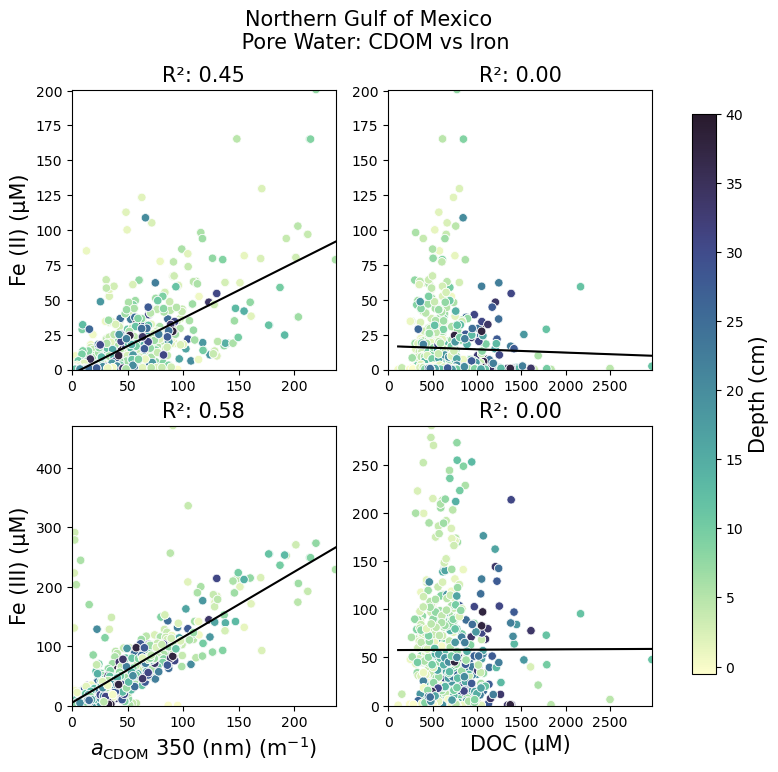

In [17]:
def cor_plot_stn_sum(data_frame, title, save_name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    
    # Set up the color bar limits
    vmin = -.5
    vmax = 40

    # Loop through the subplots
    for i, x_var in enumerate(['a350', 'NPOC_uM']):
        for j, y_var in enumerate(['Fe2_uM', 'Fe3_uM']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Sample_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Sample_depth'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

df = df_pw
cor_plot_stn_sum(df, f'Northern Gulf of Mexico \n Pore Water: CDOM vs Iron',
                 "../Dissertation_projects/Figures/Corrolation_plots/PW_DOC_IRON.png")

In [ ]:
stations = ['St.14', 'St.2', 'St.15', 'St.16', 'St.11', 'St.7', 'St.5B','St.4', 'St.MK', 'St.9', 'St.13', 'St.12', 'St.9 ']
trips = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Set up the color bar limits
vmin = df_pw['NPOC_uM'].min()
vmax = df_pw['NPOC_uM'].max()

fig, axes = plt.subplots(nrows=len(trips), ncols=len(stations), figsize=(20, 8))
for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        subset_df = df_pw[(df_pw['Trip'] == trip) & (df_pw['Station'] == station)]
        plotted = False

        if not subset_df.empty:
            #get the data
            cdom_abs = subset_df['a350']
            iron = subset_df['Fe3_uM']

            #color and plot:
            cmap=cmo.deep
            norm = plt.Normalize(vmin=df_pw['NPOC_uM'].min(), vmax=df_pw['NPOC_uM'].max())
            color = cmap(norm(subset_df["NPOC_uM"]))
            axes[i, j].scatter(iron, cdom_abs, color=color)
                
            plotted = True
            
            #set axis and lables 
            axes[i,j].set_ylim(0,220)
            axes[i,j].set_xlim(0,250)
            water_depth = df_meta[(df_meta['Trip'] == trip) & (df_meta['Station'] == station)]
            water_depth = water_depth['Water_depth'].mean()
            water_depth = round(water_depth, 1)
            axes[i, j].set_title(f'{trip} \n {station} \n {water_depth} M deep', size=12)
        else: 
            axes[i, j].axis('off')

        #set y labes 
        if j == 0:
            axes[i,j].set_ylabel(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$)', size=12, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            axes[i,j].set_ylabel('')
            axes[i,j].yaxis.set_ticklabels([])
            axes[i,j].set_yticks([])
        
        #set x labes 
        if i == 3:
            axes[i,j].set_xlabel('Fe (III) (\u03BCM)', size=12, c='black')
            axes[i,j].xaxis.set_tick_params(labelsize=10)
        else: 
            axes[i,j].set_xlabel('')
            axes[i,j].xaxis.set_ticklabels([])
            axes[i,j].set_xticks([])

#Add colorbar:
fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([.93, 0.3, 0.02, 0.6])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=0, vmax=df_pw['NPOC_uM'].max())), cax=cbar_ax)
cbar.ax.set_title(f'DOC (\u03BCM)', fontsize = 10)
cbar.ax.tick_params(labelsize=15)

#disply and save 
fig.suptitle(f'Fe(III) and CDOM by Stations and Season', size = 15)
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Corrolation_plots/Stations_Season_PW.png")

plt.show()
    

In [ ]:
stations = ['St.14', 'St.2', 'St.15', 'St.16', 'St.11', 'St.7', 'St.5B','St.4', 'St.MK', 'St.9', 'St.13', 'St.12', 'St.9 ']
trips = ['GOM21FA', 'GOM22SP', 'GOM22SU']

# Set up the color bar limits
vmin = df_bc['NPOC_uM'].min()
vmax = df_bc['NPOC_uM'].max()

fig, axes = plt.subplots(nrows=len(trips), ncols=len(stations), figsize=(20, 8))
for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        subset_df = df_bc[(df_bc['Trip'] == trip) & (df_bc['Station'] == station)]
        plotted = False

        if not subset_df.empty:
            #get the data
            cdom_abs = subset_df['a350']
            iron = subset_df['FeT_uM']

            #color and plot:
            cmap=cmo.deep
            norm = plt.Normalize(vmin=df_bc['NPOC_uM'].min(), vmax=df_bc['NPOC_uM'].max())
            color = cmap(norm(subset_df["NPOC_uM"]))
            axes[i, j].scatter(iron, cdom_abs, color=color)
                
            plotted = True
            
            #set axis and lables 
            axes[i,j].set_ylim(0,1.6209340716345813)
            axes[i,j].set_xlim(0,.575094512/4)
            water_depth = df_meta[(df_meta['Trip'] == trip) & (df_meta['Station'] == station)]
            water_depth = water_depth['Water_depth'].mean()
            water_depth = round(water_depth, 1)
            axes[i, j].set_title(f'{trip} \n {station} \n {water_depth} M deep', size=12)
        else: 
            axes[i, j].axis('off')

        #set y labes 
        if j == 0:
            axes[i,j].set_ylabel(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$)', size=12, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            axes[i,j].set_ylabel('')
            axes[i,j].yaxis.set_ticklabels([])
            axes[i,j].set_yticks([])
        
        #set x labes 
        if i == 2:
            axes[i,j].set_xlabel('Total Fe (\u03BCM)', size=12, c='black')
            axes[i,j].xaxis.set_tick_params(labelsize=10)
        else: 
            axes[i,j].set_xlabel('')
            axes[i,j].xaxis.set_ticklabels([])
            axes[i,j].set_xticks([])

#Add colorbar:
fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([.95, 0.2, 0.02, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=0, vmax=df_bc['NPOC_uM'].max())), cax=cbar_ax)
cbar.ax.set_title(f'DOC (\u03BCM)', fontsize = 10)
cbar.ax.tick_params(labelsize=15)

#disply and save 
fig.suptitle(f'Total Fe and CDOM by Stations and Season', size = 15)
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Corrolation_plots/Stations_Season_BC.png")

plt.show()
    

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Set up the color bar limits
vmin = -.5
vmax = 40

# Loop through the subplots
for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
    for j, y_var in enumerate(['a412', 'a350']):
        # Prepare the data for the subplot
        data = df_pw[[x_var, y_var, 'Sample_depth']]
        data.dropna(inplace=True)
        X = data[[x_var]]
        y = data[y_var]
        colors = data['Sample_depth'].astype(float)

        # Fit a linear regression model to the data
        model = LinearRegression()
        model.fit(X, y)
        score = model.score(X, y)

        # Plot the data and regression line
        ax = axes[j, i]
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
        sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

        # Set the axis labels and title
        if j == 1:
            ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
        else: 
            ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
        else: 
            ax.set_ylabel("")
        ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
        ax.set_ylim([0, data[y_var].max()])
        ax.set_xlim([0, data[x_var].max()])

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
# Adjust the layout of the subplots
fig.suptitle('Pore Water', size = 15)
fig.set_facecolor('w')
#plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM.png")

plt.show()

In [ ]:
def cor_plot(data_frame, title, save_name):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
    
    # Set up the color bar limits
    vmin = -.5
    vmax = 40

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Sample_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Sample_depth'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

In [ ]:
#GOM2021 
df = df_pw[df_pw['Trip'].isin(['GOM2021'])]
cor_plot(df, 'Pore Water: Summer 2021',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_summer_2021.png")

In [ ]:
# Fall 2021 
df = df_pw[df_pw['Trip'].isin(['GOM21FA'])]
cor_plot(df, 'Pore Water: Fall 2021',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_fall_2021.png")

In [ ]:
# Spring 2022
df = df_pw[df_pw['Trip'].isin(['GOM22SP'])]
cor_plot(df, 'Pore Water: Spring 2022',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_spring_2022.png")

In [ ]:
# Summer 2022 
df = df_pw[df_pw['Trip'].isin(['GOM22SU'])]
cor_plot(df, 'Pore Water: Summer 2022',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_summer_2022.png")

In [ ]:
# PW Western sites 
df = df_pw[df_pw['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
cor_plot(df, 'Pore Water: Western Sites (6,5B,4,MK)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Western.png")

In [ ]:
# Near Sites 
df = df_pw[df_pw['Station'].isin(['St.7', 'St.16', 'St.2', 'St.8', 'St.9'])]
cor_plot(df, 'Pore Water: Near Sites (7,2,16,8,9)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Near.png")

In [ ]:
# Pore water off shore sies 
df = df_pw[df_pw['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]  
cor_plot(df, 'Pore Water: Off Shore Sites (13,14,15,12,11)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Off.png")

In [ ]:
# PW Western sites Fall 2021
df = df_pw[df_pw['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot(df, 'Pore Water: Fall 2021 Western Sites (6,5B,4,MK)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Western_GOM21FA.png")

In [ ]:
# PW Western sites Spring 2022
df = df_pw[df_pw['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot(df, 'Pore Water: Spring 2022 Western Sites (6,5B,4,MK)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Western_GOM22SP.png")

In [ ]:
# PW Western sites Summer 2022
df = df_pw[df_pw['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot(df, 'Pore Water: Summer 2022 Western Sites (6,5B,4,MK)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Western_GOM22SU.png")

In [ ]:
# Near Sites Summer 2021
df = df_pw[df_pw['Station'].isin(['St.7', 'St.16', 'St.2', 'St.8', 'St.9'])]
df = df[df['Trip'].isin(['GOM2021'])]
cor_plot(df, 'Pore Water: Summer 2021 Near Sites (7,2,16,8,9)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Near_GOM2021.png")

In [ ]:
# Near Sites Fall 2021
df = df_pw[df_pw['Station'].isin(['St.7', 'St.16', 'St.2', 'St.8', 'St.9'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot(df, 'Pore Water: Fall 2021 Near Sites (7,2,16,8,9)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Near_GOM21FA.png")

In [ ]:
# Near Sites Spring 2022
df = df_pw[df_pw['Station'].isin(['St.7', 'St.16', 'St.2', 'St.8', 'St.9'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot(df, 'Pore Water: Spring 2022 Near Sites (7,2,16,8,9)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Near_GOM22SP.png")

In [ ]:
# Near Sites Summer 2022
df = df_pw[df_pw['Station'].isin(['St.7', 'St.16', 'St.2', 'St.8', 'St.9'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot(df, 'Pore Water: Summer 2022 Near Sites (7,2,16,8,9)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Near_GOM22SU.png")

In [ ]:
# Pore water off shore sies Summer 2021 
df = df_pw[df_pw['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM2021'])]
cor_plot(df, 'Pore Water: Summer 2021 Off Shore Sites (13,14,15,12,11)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Off_GOM2021.png")

In [ ]:
# Pore water off shore sies Fall 2021
df = df_pw[df_pw['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot(df, 'Pore Water: Fall 2021 Off Shore Sites (13,14,15,12,11)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Off_GOM21FA.png")

In [ ]:
# Pore water off shore sies Spring 2022
df = df_pw[df_pw['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot(df, 'Pore Water: Spring 2022 Off Shore Sites (13,14,15,12,11)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Off_GOM22SP.png")

In [ ]:
# Pore water off shore sies Summer 2022
df = df_pw[df_pw['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot(df, 'Pore Water: Summer 2022 Off Shore Sites (13,14,15,12,11)',
         "../Dissertation_projects/Figures/Corrolation_plots/PW_CDOM_Off_GOM22SU.png")

## Benthic Chamber

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Set up the color bar limits
vmin = 0
vmax = df_bc['BC_time'].max()

# Loop through the subplots
for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
    for j, y_var in enumerate(['a412', 'a350']):
        # Prepare the data for the subplot
        data = df_bc[[x_var, y_var, 'BC_time']]
        data.dropna(inplace=True)
        X = data[[x_var]]
        y = data[y_var]
        colors = data['BC_time'].astype(float)

        # Fit a linear regression model to the data
        model = LinearRegression()
        model.fit(X, y)
        score = model.score(X, y)

        # Plot the data and regression line
        ax = axes[j, i]
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.solar, vmin=vmin, vmax=vmax, legend=False)
        sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

        # Set the axis labels and title
        if j == 1:
            ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
        else: 
            ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
        else: 
            ax.set_ylabel("")
        ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
        ax.set_ylim([0, data[y_var].max()])
        ax.set_xlim([0, data[x_var].max()])

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.solar, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('Time (hours)', size = 15)
        
# Adjust the layout of the subplots
fig.suptitle('Benthic Chamber', size = 15)
fig.set_facecolor('w')
#plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM.png")

plt.show()

In [ ]:
def cor_plot_bc(data_frame, title, save_name):
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

    # Set up the color bar limits
    vmin = 0
    vmax = df_bc['BC_time'].max()

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'BC_time']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['BC_time'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.solar, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.solar, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Time (hours)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()



In [ ]:
def cor_plot_bc_alt(data_frame, title, save_name):
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

    # Set up the color bar limits
    vmin = 0
    vmax = df_bc['BC_time'].max()

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'BC_time']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['BC_time'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.solar, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.solar, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Time (hours)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()



In [ ]:
def cor_plot_bc_alt_2(data_frame, title, save_name):
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12.5, 8))

    # Set up the color bar limits
    vmin = 0
    vmax = df_bc['BC_time'].max()

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'BC_time']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['BC_time'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.solar, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.solar, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Time (hours)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()



In [ ]:
# GOM21FA 
df = df_bc[df_bc['Trip'].isin(['GOM21FA'])]
cor_plot_bc(df, 'Benthic Chamber: Fall 2021', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_fall_2021.png")

In [ ]:
# GOM22SP
df = df_bc[df_bc['Trip'].isin(['GOM22SP'])]
cor_plot_bc(df, 'Benthic Chamber: Spring 2022', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_spring_2022.png")

In [ ]:
# GOM22SU
df = df_bc[df_bc['Trip'].isin(['GOM22SU'])]
cor_plot_bc(df, 'Benthic Chamber: Summer 2022', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_summer_2022.png")

In [ ]:
# Western
df = df_bc[df_bc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
cor_plot_bc(df, 'Benthic Chamber: Western Sites (6,5b,4,MK)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Western.png")

In [ ]:
# Near
df = df_bc[df_bc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
cor_plot_bc(df, 'Benthic Chamber: Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Near.png")

In [ ]:
# Off
df = df_bc[df_bc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
cor_plot_bc(df, 'Benthic Chamber: Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Off.png")

In [ ]:
# Western Summer 2022
df = df_bc[df_bc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_bc(df, 'Benthic Chamber: Summer 2022 Western Sites (6,5b,4,MK)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Western_GOM22SU.png")

In [ ]:
# Near Summer 2022
df = df_bc[df_bc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_bc(df, 'Benthic Chamber: Summer 2022 Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Near_GOM22SU.png")

In [ ]:
# Off Summer 2022
df = df_bc[df_bc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_bc(df, 'Benthic Chamber: Summer 2022 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Off_GOM22SU.png")

In [ ]:
# Western Spring 2022
df = df_bc[df_bc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_bc_alt_2(df, 'Benthic Chamber: Spring 2022 Western Sites (6,5b,4,MK)', 
                "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Western_GOM22SP.png")

In [ ]:
# Near Spring 2022
df = df_bc[df_bc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_bc(df, 'Benthic Chamber: Spring 2022 Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Near_GOM22SP.png")

In [ ]:
# Off Spring 2022
df = df_bc[df_bc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_bc(df, 'Benthic Chamber: Spring 2022 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Off_GOM22SP.png")

In [ ]:
# Western Fall 2021
df = df_bc[df_bc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_bc_alt_2(df, 'Benthic Chamber: Fall 2021 Western Sites (6,5b,4,MK)', 
                "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Western_GOM21FA.png")

In [ ]:
# Near Fall 2021
df = df_bc[df_bc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_bc_alt(df, 'Benthic Chamber: Fall 2021 Near Sites (7,2,16,8,9)', 
                "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Near_GOM21FA.png")

In [ ]:
# Off Fall 2021
df = df_bc[df_bc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_bc(df, 'Benthic Chamber: Fall 2021 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/BC_CDOM_Off_GOM21FA.png")

## Rhizone 

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Set up the color bar limits
vmin = 0
vmax = 16.5

# Loop through the subplots
for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
    for j, y_var in enumerate(['a412', 'a350']):
        # Prepare the data for the subplot
        data = df_rz[[x_var, y_var, 'Sample_depth']]
        data.dropna(inplace=True)
        X = data[[x_var]]
        y = data[y_var]
        colors = data['Sample_depth'].astype(float)

        # Fit a linear regression model to the data
        model = LinearRegression()
        model.fit(X, y)
        score = model.score(X, y)

        # Plot the data and regression line
        ax = axes[j, i]
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
        sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

        # Set the axis labels and title
        if j == 1:
            ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
        else: 
            ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
        else: 
            ax.set_ylabel("")
        ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
        ax.set_ylim([0, data[y_var].max()])
        ax.set_xlim([0, data[x_var].max()])

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
# Adjust the layout of the subplots
fig.suptitle('Rhizon Pore Water', size = 15)
fig.set_facecolor('w')
#plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM.png")

plt.show()

In [ ]:
def cor_plot_rz(data_frame, title, save_name):

    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

    # Set up the color bar limits
    vmin = 0
    vmax = 16.5

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Sample_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Sample_depth'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

In [ ]:
def cor_plot_rz_no_doc(data_frame, title, save_name):

    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    # Set up the color bar limits
    vmin = 0
    vmax = 16.5

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Sample_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Sample_depth'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Depth (cm)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

In [ ]:
# GOM21FA 
df = df_rz[df_rz['Trip'].isin(['GOM21FA'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Fall 2021', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_fall_2021.png")

In [ ]:
# GOM22SP
df = df_rz[df_rz['Trip'].isin(['GOM22SP'])]
cor_plot_rz(df, 'Rhizon Pore Water: Spring 2022', 
            "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_spring_2022.png")

In [ ]:
# GOM22SU
df = df_rz[df_rz['Trip'].isin(['GOM22SU'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Summer 2022', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_summer_2022.png")

In [ ]:
# Western
df = df_rz[df_rz['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Western Sites (6,5b,4,MK)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Western.png")

In [ ]:
# Near
df = df_rz[df_rz['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
cor_plot_rz(df, 'Rhizon Pore Water: Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Near.png")

In [ ]:
# Off
df = df_rz[df_rz['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
cor_plot_rz(df, 'Rhizon Pore Water: Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Off.png")

In [ ]:
# Western Summer 2022
df = df_rz[df_rz['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Summer 2022 Western Sites (6,5b,4,MK)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Western_GOM22SU.png")

In [ ]:
# Near Summer 2022
df = df_rz[df_rz['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Summer 2022 Near Sites (7,2,16,8,9)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Near_GOM22SU.png")

In [ ]:
# Off Summer 2022
df = df_rz[df_rz['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Summer 2022 Off Shore Sites (13,14,15,12,11)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Off_GOM22SU.png")

In [ ]:
# Western Spring 2022
df = df_rz[df_rz['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Spring 2022 Western Sites (6,5b,4,MK)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Western_GOM22SP.png")

In [ ]:
# Near Spring 2022
df = df_rz[df_rz['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_rz(df, 'Rhizon Pore Water: Spring 2022 Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Near_GOM22SP.png")

In [ ]:
# Off Spring 2022
df = df_rz[df_rz['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_rz(df, 'Rhizon Pore Water: Spring 2022 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Off_GOM22SP.png")

# Western Fall 2021
df = df_rz[df_rz['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_rz(df, 'Rhizon Pore Water: Fall 2021 Western Sites (6,5b,4,MK)', 
            "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Western_GOM21FA.png")
            
NOT WORK

In [ ]:
# Near Fall 2021
df = df_rz[df_rz['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Fall 2021 Near Sites (7,2,16,8,9)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Near_GOM21FA.png")

In [ ]:
# Off Fall 2021
df = df_rz[df_rz['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_rz_no_doc(df, 'Rhizon Pore Water: Fall 2021 Off Shore Sites (13,14,15,12,11)', 
                   "../Dissertation_projects/Figures/Corrolation_plots/RZ_CDOM_Off_GOM21FA.png")

## Water Column 

In [ ]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Set up the color bar limits
vmin = np.log(df_wc['Water_depth'].min())
vmax = np.log(df_wc['Water_depth'].max())

# Loop through the subplots
for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
    for j, y_var in enumerate(['a412', 'a350']):
        # Prepare the data for the subplot
        data = df_wc[[x_var, y_var, 'Water_depth']]
        data.dropna(inplace=True)
        X = data[[x_var]]
        y = data[y_var]
        colors = np.log(data['Water_depth'].astype(float))

        # Fit a linear regression model to the data
        model = LinearRegression()
        model.fit(X, y)
        score = model.score(X, y)

        # Plot the data and regression line
        ax = axes[j, i]
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.matter, vmin=vmin, vmax=vmax, legend=False)
        sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

        # Set the axis labels and title
        if j == 1:
            ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
        else: 
            ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
        else: 
            ax.set_ylabel("")
        ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
        ax.set_ylim([0, data[y_var].max()])
        ax.set_xlim([0, data[x_var].max()])

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.matter, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('Log scale Water Depth (M)', size = 15)
        
# Adjust the layout of the subplots
fig.suptitle('Water Column', size = 15)
fig.set_facecolor('w')
#plt.tight_layout()

plt.savefig("../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM.png")

plt.show()

In [ ]:
def cor_plot_wc(data_frame, title, save_name):
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

    # Set up the color bar limits
    vmin = np.log(df_wc['Water_depth'].min())
    vmax = np.log(df_wc['Water_depth'].max())

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM', 'NPOC_uM', 'TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Water_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = np.log(data['Water_depth'].astype(float))

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.matter, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.matter, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Log scale Water Depth (M)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

In [ ]:
# GOM21FA 
df = df_wc[df_wc['Trip'].isin(['GOM21FA'])]
cor_plot_wc(df, 'Water Column: Fall 2021', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_fall_2021.png")

In [ ]:
# GOM22SP
df = df_wc[df_wc['Trip'].isin(['GOM22SP'])]
cor_plot_wc(df, 'Water Column: Spring 2022', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_spring_2022.png")

In [ ]:
# GOM22SU
df = df_wc[df_wc['Trip'].isin(['GOM22SU'])]
cor_plot_wc(df, 'Water Column: Summer 2022', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_summer_2022.png")

In [ ]:
# Western
df = df_wc[df_wc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
cor_plot_wc(df, 'Water Column: Western Sites (6,5b,4,MK)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Western.png")

In [ ]:
# Near
df = df_wc[df_wc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
cor_plot_wc(df, 'Water Column: Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Near.png")

In [ ]:
# Off
df = df_wc[df_wc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
cor_plot_wc(df, 'Water Column: Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Off.png")

In [ ]:
# Near Summer 2022
df = df_wc[df_wc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_wc(df, 'Water Column: Summer 2022 Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Near_GOM22SU.png")

In [ ]:
# Off Summer 2022
df = df_wc[df_wc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_wc(df, 'Water Column: Summer 2022 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Off_GOM22SU.png")

In [ ]:
# Western Spring 2022
df = df_wc[df_wc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_wc(df, 'Water Column: Spring 2022 Western Sites (6,5b,4,MK)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Western_GOM22SP.png")

In [ ]:
# Near Spring 2022
df = df_wc[df_wc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_wc(df, 'Benthic Chamber: Spring 2022 Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Near_GOM22SP.png")

In [ ]:
# Off Spring 2022
df = df_wc[df_wc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM22SP'])]
cor_plot_wc(df, 'Water Column: Spring 2022 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Off_GOM22SP.png")

In [ ]:
# Near Fall 2021
df = df_wc[df_wc['Station'].isin(['St.7', 'St.2', 'St.16', 'St.9', 'St.8'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_wc(df, 'Water Column: Fall 2021 Near Sites (7,2,16,8,9)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Near_GOM21FA.png")

In [ ]:
# Off Fall 2021
df = df_wc[df_wc['Station'].isin(['St.13', 'St.14', 'St.15', 'St.12', 'St.11'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_wc(df, 'Water Column: Fall 2021 Off Shore Sites (13,14,15,12,11)', 
            "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Off_GOM21FA.png")

In [ ]:
def cor_plot_wc_3(data_frame, title, save_name):
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))

    # Set up the color bar limits
    vmin = np.log(df_wc['Water_depth'].min())
    vmax = np.log(df_wc['Water_depth'].max())

    # Loop through the subplots
    for i, x_var in enumerate(['FeT_uM','NPOC_uM','TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Water_depth']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = np.log(data['Water_depth'].astype(float))

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.matter, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.matter, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Log scale Water Depth (M)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()
    
# Western Fall 2021
df = df_wc[df_wc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM21FA'])]
cor_plot_wc_3(df, 'Water Column: Fall 2021 Western Sites (6,5b,4,MK)', 
              "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Western_GOM21FA.png")

def cor_plot_wc_2(data_frame, title, save_name):
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

    # Set up the color bar limits
    vmin = np.log(df_wc['Water_depth'].min())
    vmax = np.log(df_wc['Water_depth'].max())

    # Loop through the subplots
    for i, x_var in enumerate(['Fe2_uM','Fe3_uM','FeT_uM','NPOC_uM','TN_uM']):
        for j, y_var in enumerate(['a412', 'a350']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Water_depth']]
            #data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = np.log(data['Water_depth'].astype(float))

            #Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.matter, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            ax.set_ylim([0, data[y_var].max()])
            ax.set_xlim([0, data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.matter, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Log scale Water Depth (M)', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()

    plt.savefig(save_name)

    plt.show()

# Western Summer 2022
df = df_bc[df_bc['Station'].isin(['St.6', 'St.5B', 'St.4', 'St.MK'])]
df = df[df['Trip'].isin(['GOM22SU'])]
cor_plot_wc_2(df, 'Water Column: Summer 2022 Western Sites (6,5b,4,MK)', 
              "../Dissertation_projects/Figures/Corrolation_plots/WC_CDOM_Western_GOM22SU.png")

## Part 2 : Modeling

In [ ]:
#Water Column
# Define the model formula
#formula = 'a350 ~ NPOC_uM*TN_uM*FeT_uM' #0.407
#formula = 'a350 ~ NPOC_uM*FeT_uM*TN_uM' #0.407
#formula = 'a350 ~ NPOC_uM*TN_uM' #0.259
formula = 'a350 ~ NPOC_uM*Fe2_uM' #0.747
#formula = 'a350 ~ NPOC_uM*Fe3_uM' #0.320
#formula = 'a350 ~ NPOC_uM*FeT_uM' #0.271
#formula = 'a350 ~ TN_uM*Fe2_uM' #0.468
#formula = 'a350 ~ TN_uM*Fe3_uM' #0.386
#formula = 'a350 ~ TN_uM*FeT_uM' #0.031


# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_wc).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)


In [ ]:
#Benthic chamber
# Define the model formula
#formula = 'a350 ~ NPOC_uM*TN_uM*FeT_uM' #.264
#formula = 'a350 ~ NPOC_uM*FeT_uM*TN_uM' #.264
#formula = 'a350 ~ NPOC_uM*TN_uM' #.239
#formula = 'a350 ~ NPOC_uM*Fe2_uM' #.228
#formula = 'a350 ~ NPOC_uM*Fe3_uM' #.259
formula = 'a350 ~ NPOC_uM*FeT_uM' #.262

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_bc).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)


In [ ]:
#Pore Water
# Define the model formula
#formula = 'a350 ~ Fe3_uM+NPOC_uM' #.419 
#formula = 'a350 ~ Fe3_uM' #.338 
#formula = 'a350 ~ Fe3_uM+TN_uM' #.428 
#formula = 'a350 ~ Fe3_uM*NPOC_uM' #.420 
#formula = 'a350 ~ Fe3_uM*TN_uM' #.489 
#formula = 'a350 ~ Fe3_uM+TN_uM*NPOC_uM' #.444
#formula = 'a350 ~ Fe3_uM*TN_uM+NPOC_uM' #.490
#formula = 'a350 ~ Fe3_uM*NPOC_uM+TN_uM' #.432
formula = 'a350 ~ Fe3_uM*TN_uM*NPOC_uM' #.503

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_pw).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)


In [ ]:
#Pore Water Rhizon
# Define the model formula
#formula = 'a350 ~ Fe3_uM+NPOC_uM' #0.361
#formula = 'a350 ~ Fe3_uM' #0.130
#formula = 'a350 ~ Fe3_uM+TN_uM' #0.403
#formula = 'a350 ~ Fe3_uM*NPOC_uM' #0.702
#formula = 'a350 ~ Fe3_uM*TN_uM' # 0.638
#formula = 'a350 ~ Fe3_uM+TN_uM*NPOC_uM' #0.661
#formula = 'a350 ~ Fe3_uM*TN_uM+NPOC_uM' #0.759
#formula = 'a350 ~ Fe3_uM*NPOC_uM+TN_uM' #0.838
formula = 'a350 ~ Fe3_uM*TN_uM*NPOC_uM' #0.912

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_rz).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)
